In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0


In [2]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 450kB 49.1MB/s 
     |████████████████████████████████| 3.8MB 46.8MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=5ee646e07a152d2cc21223d6a567d2fb083c79aac4962b8ea5e4a9a3edfd8735
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [3]:
!pip install keras-tuner==1.0.0 --no-dependencies

     |████████████████████████████████| 92kB 7.8MB/s 


In [9]:
!pip install terminaltables colorama

ERROR: keras-tuner 1.0.0 requires tensorflow>=2.0.0-beta1, which is not installed.


In [288]:
import tensorflow as tf
import kerastuner as kt
import matplotlib.pyplot as plt


In [289]:
(train_images, train_labels), (test_images, test_labels) =\
    tf.keras.datasets.fashion_mnist.load_data()

In [290]:
import numpy as np
train_images = np.asarray(train_images, dtype=np.float32) / 255.0
test_images = np.asarray(test_images, dtype=np.float32) / 255.0
train_images = train_images.reshape(60000,784)
test_images = test_images.reshape(10000,784)

In [291]:
train_labels = tf.keras.utils.to_categorical(train_labels)

In [292]:
dataset = tf.data.Dataset.from_tensor_slices((train_images.astype(np.float32),
                                              train_labels.astype(np.float32)))

In [293]:
k = 0
for i in dataset:
  print(i)
  if k==2:
    break
  k+=1

(<tf.Tensor: id=1018192, shape=(784,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
 

In [294]:
!rm -rf results


In [295]:
class my_layer(tf.keras.layers.Layer):
  
  def __init__(self,ou):
    super(my_layer,self).__init__()
    
    
    self.W = tf.Variable(initial_value=np.random.randn(784,ou),trainable = True, dtype = tf.float32)
  def call(self,inputs):
    
    return tf.nn.relu(tf.matmul(inputs,self.W))

In [296]:
def build_model(hp):
  """Builds a dnn model."""
  class mod(tf.keras.Model):
    def __init__(self):
      super(mod,self).__init__()
      ou = hp.Int('nou', 120, 200, step=20, default=120)
      ou1 = hp.Int('nou_w', 120, 200, step=20, default=120)
      self.layer0 = my_layer(ou1)
      self.layer1 = tf.keras.layers.Dense(ou,activation = tf.nn.relu)
      self.layer2 = tf.keras.layers.Dense(10,activation = tf.nn.softmax)
    def call(self,inputs):
      return self.layer2(self.layer1(self.layer0(inputs)))
  model = mod()
  
  return model
  
 

In [297]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=200):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

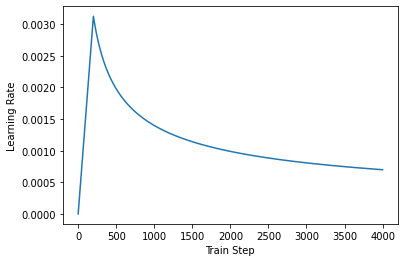

In [298]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(4000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [299]:
def get_loss(lab,logits):
  return tf.keras.losses.categorical_crossentropy(lab,logits)

In [300]:

class MyTuner(kt.Tuner):

    def run_trial(self, trial, train_ds):
        hp = trial.hyperparameters
        
        # Hyperparameters can be added anywhere inside `run_trial`.
        # When the first trial is run, they will take on their default values.
        # Afterwards, they will be tuned by the `Oracle`.
        
        train_ds = train_ds.batch(
            hp.Int('batch_size', 32, 128, step=32, default=64))
        
        model = self.hypermodel.build(trial.hyperparameters)
        lr = CustomSchedule(512)
        #lr = 0.001
        optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
        epoch_loss_metric = tf.keras.metrics.Mean()
        
        @tf.function
        def run_train_step(images,lab):
            with tf.GradientTape() as t:
              logits = model(images)
              loss = tf.reduce_mean(get_loss(lab,logits))
              grads = t.gradient(loss, model.trainable_variables)
      
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss_metric.update_state(loss)
            return loss
        # `self.on_epoch_end` reports results to the `Oracle` and saves the
        # current state of the Model. The other hooks called here only log values
        # for display but can also be overridden. For use cases where there is no
        # natural concept of epoch, you do not have to call any of these hooks. In
        # this case you should instead call `self.oracle.update_trial` and
        # `self.oracle.save_model` manually.
        for epoch in range(5):
            print('Epoch: {}'.format(epoch))

            #self.on_epoch_begin(trial, model, epoch, logs={})
            for (batch, (images, lab)) in enumerate(train_ds):
                
                batch_loss = float(run_train_step(images,lab))
                

                if batch % 100 == 0:
                    loss = epoch_loss_metric.result().numpy()
                    print('Batch: {}, Average Loss: {}'.format(batch, loss))

            epoch_loss = epoch_loss_metric.result().numpy()
            self.on_epoch_end(trial, model, epoch, logs={'fin_loss': epoch_loss})
            epoch_loss_metric.reset_states()


In [301]:
tuner = MyTuner(
oracle=kt.oracles.BayesianOptimization(
          objective=kt.Objective('fin_loss', 'min'),
          max_trials=10),
      hypermodel=build_model,
      directory='results',
      project_name='mnist_custom_training')


tuner.search(train_ds=dataset)

Epoch: 0
Batch: 0, Average Loss: 12.076967239379883
Batch: 100, Average Loss: 3.3560736179351807
Batch: 200, Average Loss: 2.099210023880005
Batch: 300, Average Loss: 1.6218373775482178
Batch: 400, Average Loss: 1.3575841188430786
Batch: 500, Average Loss: 1.1896796226501465
Batch: 600, Average Loss: 1.070132851600647
Batch: 700, Average Loss: 0.9815959334373474
Batch: 800, Average Loss: 0.9140570759773254
Batch: 900, Average Loss: 0.8631505370140076
Epoch: 1
Batch: 0, Average Loss: 0.26577359437942505
Batch: 100, Average Loss: 0.4066585600376129
Batch: 200, Average Loss: 0.3984401822090149
Batch: 300, Average Loss: 0.39640510082244873
Batch: 400, Average Loss: 0.39208269119262695
Batch: 500, Average Loss: 0.3850157856941223
Batch: 600, Average Loss: 0.3784024715423584
Batch: 700, Average Loss: 0.37246814370155334
Batch: 800, Average Loss: 0.3685401380062103
Batch: 900, Average Loss: 0.3673023581504822
Epoch: 2
Batch: 0, Average Loss: 0.23862552642822266
Batch: 100, Average Loss: 0.329

Epoch: 0
Batch: 0, Average Loss: 12.097491264343262
Batch: 100, Average Loss: 3.01611590385437
Batch: 200, Average Loss: 1.9168646335601807
Batch: 300, Average Loss: 1.4915225505828857
Batch: 400, Average Loss: 1.249793529510498
Batch: 500, Average Loss: 1.0968410968780518
Batch: 600, Average Loss: 0.9915791749954224
Epoch: 1
Batch: 0, Average Loss: 0.31301358342170715
Batch: 100, Average Loss: 0.4208567440509796
Batch: 200, Average Loss: 0.4102117419242859
Batch: 300, Average Loss: 0.40157651901245117
Batch: 400, Average Loss: 0.39401674270629883
Batch: 500, Average Loss: 0.38698291778564453
Batch: 600, Average Loss: 0.38227689266204834
Epoch: 2
Batch: 0, Average Loss: 0.2318422794342041
Batch: 100, Average Loss: 0.33225375413894653
Batch: 200, Average Loss: 0.32803428173065186
Batch: 300, Average Loss: 0.3229156732559204
Batch: 400, Average Loss: 0.3193384110927582
Batch: 500, Average Loss: 0.31584101915359497
Batch: 600, Average Loss: 0.3140746057033539
Epoch: 3
Batch: 0, Average Lo

Epoch: 0
Batch: 0, Average Loss: 13.63520336151123
Batch: 100, Average Loss: 3.2873456478118896
Batch: 200, Average Loss: 2.0410690307617188
Batch: 300, Average Loss: 1.5752248764038086
Batch: 400, Average Loss: 1.3173646926879883
Batch: 500, Average Loss: 1.152150273323059
Batch: 600, Average Loss: 1.0394786596298218
Epoch: 1
Batch: 0, Average Loss: 0.3330496847629547
Batch: 100, Average Loss: 0.4405684769153595
Batch: 200, Average Loss: 0.43040379881858826
Batch: 300, Average Loss: 0.41970691084861755
Batch: 400, Average Loss: 0.41045233607292175
Batch: 500, Average Loss: 0.4018324613571167
Batch: 600, Average Loss: 0.39561957120895386
Epoch: 2
Batch: 0, Average Loss: 0.25329867005348206
Batch: 100, Average Loss: 0.3478280007839203
Batch: 200, Average Loss: 0.3494602143764496
Batch: 300, Average Loss: 0.3440748155117035
Batch: 400, Average Loss: 0.33864161372184753
Batch: 500, Average Loss: 0.33348000049591064
Batch: 600, Average Loss: 0.33074429631233215
Epoch: 3
Batch: 0, Average L

Epoch: 0
Batch: 0, Average Loss: 18.19675064086914
Batch: 100, Average Loss: 4.323172092437744
Batch: 200, Average Loss: 2.5750367641448975
Batch: 300, Average Loss: 1.9258428812026978
Batch: 400, Average Loss: 1.5789939165115356
Batch: 500, Average Loss: 1.3606324195861816
Batch: 600, Average Loss: 1.2109159231185913
Epoch: 1
Batch: 0, Average Loss: 0.3409848213195801
Batch: 100, Average Loss: 0.43158161640167236
Batch: 200, Average Loss: 0.4275985658168793
Batch: 300, Average Loss: 0.41324275732040405
Batch: 400, Average Loss: 0.40489304065704346
Batch: 500, Average Loss: 0.39608901739120483
Batch: 600, Average Loss: 0.3911406695842743
Epoch: 2
Batch: 0, Average Loss: 0.24610395729541779
Batch: 100, Average Loss: 0.34051287174224854
Batch: 200, Average Loss: 0.34297415614128113
Batch: 300, Average Loss: 0.33645665645599365
Batch: 400, Average Loss: 0.3328079879283905
Batch: 500, Average Loss: 0.3281305730342865
Batch: 600, Average Loss: 0.326603502035141
Epoch: 3
Batch: 0, Average Lo

Epoch: 0
Batch: 0, Average Loss: 9.793546676635742
Batch: 100, Average Loss: 3.2947356700897217
Batch: 200, Average Loss: 2.1552977561950684
Batch: 300, Average Loss: 1.699903130531311
Batch: 400, Average Loss: 1.429388403892517
Batch: 500, Average Loss: 1.2572003602981567
Batch: 600, Average Loss: 1.1430078744888306
Batch: 700, Average Loss: 1.0533990859985352
Batch: 800, Average Loss: 0.986462414264679
Batch: 900, Average Loss: 0.928889274597168
Batch: 1000, Average Loss: 0.8807727694511414
Batch: 1100, Average Loss: 0.8419824838638306
Batch: 1200, Average Loss: 0.81171053647995
Batch: 1300, Average Loss: 0.7833541631698608
Batch: 1400, Average Loss: 0.7588273286819458
Batch: 1500, Average Loss: 0.7375608682632446
Batch: 1600, Average Loss: 0.7184645533561707
Batch: 1700, Average Loss: 0.7025134563446045
Batch: 1800, Average Loss: 0.6872672438621521
Epoch: 1
Batch: 0, Average Loss: 0.29323387145996094
Batch: 100, Average Loss: 0.40205058455467224
Batch: 200, Average Loss: 0.397995918

Epoch: 0
Batch: 0, Average Loss: 12.002044677734375
Batch: 100, Average Loss: 3.4123358726501465
Batch: 200, Average Loss: 2.1059823036193848
Batch: 300, Average Loss: 1.6015771627426147
Batch: 400, Average Loss: 1.3265650272369385
Epoch: 1
Batch: 0, Average Loss: 0.3937363624572754
Batch: 100, Average Loss: 0.4418632686138153
Batch: 200, Average Loss: 0.44190698862075806
Batch: 300, Average Loss: 0.42535871267318726
Batch: 400, Average Loss: 0.4124586582183838
Epoch: 2
Batch: 0, Average Loss: 0.2716245651245117
Batch: 100, Average Loss: 0.35612383484840393
Batch: 200, Average Loss: 0.3602593243122101
Batch: 300, Average Loss: 0.3517549932003021
Batch: 400, Average Loss: 0.3448539078235626
Epoch: 3
Batch: 0, Average Loss: 0.21671278774738312
Batch: 100, Average Loss: 0.3120724558830261
Batch: 200, Average Loss: 0.3170376420021057
Batch: 300, Average Loss: 0.31087231636047363
Batch: 400, Average Loss: 0.3065994083881378
Epoch: 4
Batch: 0, Average Loss: 0.18468746542930603
Batch: 100, Av

Epoch: 0
Batch: 0, Average Loss: 12.624363899230957
Batch: 100, Average Loss: 3.4828741550445557
Batch: 200, Average Loss: 2.172593355178833
Batch: 300, Average Loss: 1.6649309396743774
Batch: 400, Average Loss: 1.382293939590454
Batch: 500, Average Loss: 1.2069162130355835
Batch: 600, Average Loss: 1.0876576900482178
Epoch: 1
Batch: 0, Average Loss: 0.3547945022583008
Batch: 100, Average Loss: 0.4377260208129883
Batch: 200, Average Loss: 0.43394362926483154
Batch: 300, Average Loss: 0.4197690784931183
Batch: 400, Average Loss: 0.4107525944709778
Batch: 500, Average Loss: 0.4029659926891327
Batch: 600, Average Loss: 0.39871713519096375
Epoch: 2
Batch: 0, Average Loss: 0.25154557824134827
Batch: 100, Average Loss: 0.34673815965652466
Batch: 200, Average Loss: 0.34980693459510803
Batch: 300, Average Loss: 0.34260690212249756
Batch: 400, Average Loss: 0.3377698063850403
Batch: 500, Average Loss: 0.3323744833469391
Batch: 600, Average Loss: 0.33151158690452576
Epoch: 3
Batch: 0, Average Lo

Epoch: 0
Batch: 0, Average Loss: 7.406989574432373
Batch: 100, Average Loss: 2.6277694702148438
Batch: 200, Average Loss: 1.8220843076705933
Batch: 300, Average Loss: 1.4537571668624878
Batch: 400, Average Loss: 1.2393184900283813
Batch: 500, Average Loss: 1.1023956537246704
Batch: 600, Average Loss: 1.0117313861846924
Batch: 700, Average Loss: 0.9365993738174438
Batch: 800, Average Loss: 0.8826814293861389
Batch: 900, Average Loss: 0.8366691470146179
Batch: 1000, Average Loss: 0.7975728511810303
Batch: 1100, Average Loss: 0.7649135589599609
Batch: 1200, Average Loss: 0.7388320565223694
Batch: 1300, Average Loss: 0.7148988842964172
Batch: 1400, Average Loss: 0.6933408379554749
Batch: 1500, Average Loss: 0.6758251190185547
Batch: 1600, Average Loss: 0.6600152850151062
Batch: 1700, Average Loss: 0.6474039554595947
Batch: 1800, Average Loss: 0.634393036365509
Epoch: 1
Batch: 0, Average Loss: 0.41277459263801575
Batch: 100, Average Loss: 0.40757426619529724
Batch: 200, Average Loss: 0.3931

Epoch: 0
Batch: 0, Average Loss: 8.54290771484375
Batch: 100, Average Loss: 2.6425113677978516
Batch: 200, Average Loss: 1.7689409255981445
Batch: 300, Average Loss: 1.412920355796814
Batch: 400, Average Loss: 1.2085230350494385
Batch: 500, Average Loss: 1.0724027156829834
Batch: 600, Average Loss: 0.9810242652893066
Batch: 700, Average Loss: 0.9054693579673767
Batch: 800, Average Loss: 0.851116955280304
Batch: 900, Average Loss: 0.8069913983345032
Epoch: 1
Batch: 0, Average Loss: 0.33755505084991455
Batch: 100, Average Loss: 0.42674216628074646
Batch: 200, Average Loss: 0.42069703340530396
Batch: 300, Average Loss: 0.42093464732170105
Batch: 400, Average Loss: 0.41440480947494507
Batch: 500, Average Loss: 0.4061152935028076
Batch: 600, Average Loss: 0.4033909738063812
Batch: 700, Average Loss: 0.396137535572052
Batch: 800, Average Loss: 0.39171668887138367
Batch: 900, Average Loss: 0.388923317193985
Epoch: 2
Batch: 0, Average Loss: 0.27991724014282227
Batch: 100, Average Loss: 0.35047

Epoch: 0
Batch: 0, Average Loss: 13.76427936553955
Batch: 100, Average Loss: 3.3301842212677
Batch: 200, Average Loss: 2.253934144973755
Batch: 300, Average Loss: 1.7480144500732422
Batch: 400, Average Loss: 1.461559534072876
Batch: 500, Average Loss: 1.276032567024231
Batch: 600, Average Loss: 1.1519694328308105
Batch: 700, Average Loss: 1.0582306385040283
Batch: 800, Average Loss: 0.9883582592010498
Batch: 900, Average Loss: 0.929518461227417
Batch: 1000, Average Loss: 0.8801169395446777
Batch: 1100, Average Loss: 0.8408903479576111
Batch: 1200, Average Loss: 0.8088165521621704
Batch: 1300, Average Loss: 0.779218852519989
Batch: 1400, Average Loss: 0.7531381249427795
Batch: 1500, Average Loss: 0.7313189506530762
Batch: 1600, Average Loss: 0.7119705080986023
Batch: 1700, Average Loss: 0.6959987282752991
Batch: 1800, Average Loss: 0.6804043054580688
Epoch: 1
Batch: 0, Average Loss: 0.2297326624393463
Batch: 100, Average Loss: 0.4054342210292816
Batch: 200, Average Loss: 0.3902331590652

INFO:tensorflow:Oracle triggered exit


In [302]:
m = tuner.get_best_models()[0]

In [303]:
k = 0
for i in dataset:
  #print(i[1])
  print('REAL -> {}'.format(np.argmax(i[1])))
  pred = m(i[0][np.newaxis,:])
  print('PRED -> {}'.format(np.argmax(pred,axis = 1)))
  k+=1
  if k==50:
    break


REAL -> 9
PRED -> [9]
REAL -> 0
PRED -> [0]
REAL -> 0
PRED -> [0]
REAL -> 3
PRED -> [3]
REAL -> 0
PRED -> [3]
REAL -> 2
PRED -> [2]
REAL -> 7
PRED -> [7]
REAL -> 2
PRED -> [2]
REAL -> 5
PRED -> [5]
REAL -> 5
PRED -> [5]
REAL -> 0
PRED -> [0]
REAL -> 9
PRED -> [9]
REAL -> 5
PRED -> [5]
REAL -> 5
PRED -> [5]
REAL -> 7
PRED -> [7]
REAL -> 9
PRED -> [9]
REAL -> 1
PRED -> [1]
REAL -> 0
PRED -> [0]
REAL -> 6
PRED -> [6]
REAL -> 4
PRED -> [4]
REAL -> 3
PRED -> [3]
REAL -> 1
PRED -> [1]
REAL -> 4
PRED -> [4]
REAL -> 8
PRED -> [8]
REAL -> 4
PRED -> [2]
REAL -> 3
PRED -> [3]
REAL -> 0
PRED -> [0]
REAL -> 2
PRED -> [2]
REAL -> 4
PRED -> [4]
REAL -> 4
PRED -> [4]
REAL -> 5
PRED -> [5]
REAL -> 3
PRED -> [3]
REAL -> 6
PRED -> [6]
REAL -> 6
PRED -> [6]
REAL -> 0
PRED -> [0]
REAL -> 8
PRED -> [8]
REAL -> 5
PRED -> [5]
REAL -> 2
PRED -> [2]
REAL -> 1
PRED -> [1]
REAL -> 6
PRED -> [6]
REAL -> 6
PRED -> [6]
REAL -> 7
PRED -> [7]
REAL -> 9
PRED -> [9]
REAL -> 5
PRED -> [5]
REAL -> 9
PRED -> [9]
REAL -> 2


In [304]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'nou': 200, 'nou_w': 160, 'batch_size': 96}


In [305]:
for i in tuner.get_best_hyperparameters(num_trials = 10):
  print(i.values)

{'nou': 200, 'nou_w': 160, 'batch_size': 96}
{'nou': 200, 'nou_w': 200, 'batch_size': 32}
{'nou': 200, 'nou_w': 140, 'batch_size': 64}
{'nou': 160, 'nou_w': 180, 'batch_size': 32}
{'nou': 160, 'nou_w': 140, 'batch_size': 32}
{'nou': 140, 'nou_w': 160, 'batch_size': 96}
{'nou': 140, 'nou_w': 180, 'batch_size': 96}
{'nou': 160, 'nou_w': 160, 'batch_size': 96}
{'nou': 140, 'nou_w': 140, 'batch_size': 64}
{'nou': 120, 'nou_w': 160, 'batch_size': 128}


In [306]:
tuner.results_summary()
